# Hyperparameter Tuning

Scikit-learn documentation:
* [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
* [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
* [Breast Cancer dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/murilogustineli/hype-tuning/blob/main/gridsearch.ipynb)

### Import libraries

In [21]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load sklearn libraries
from sklearn import tree
from sklearn.datasets import load_breast_cancer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import (
    train_test_split, learning_curve, validation_curve,
    StratifiedKFold, GridSearchCV, RandomizedSearchCV)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    make_scorer, classification_report)

### Helper functions

In [ ]:
# Rename columns to lower case
def rename_columns(df: pd.DataFrame, ) -> pd.DataFrame:
    # Rename columns to lower case
    cols = list(df.columns)
    lower_cols = [col.replace(" ", "_").lower() for col in cols]
    df.columns = lower_cols
    return df


# Load breast cancer dataset from sklearn
def load_breast_cancer_data():
    X, y = load_breast_cancer(return_X_y=True, as_frame=True)
    # Rename columns
    X = rename_columns(df=X)
    return X, y


# Preprocess data
def preprocess_data(load_data, test_size=0.2, oversample=False):
    # Load dataset
    X, y = load_data

    # Train/Test Split using Stratified Sampling
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42)

    # Oversampling using SMOTE
    if oversample:
        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train)

    return X_train, X_test, y_train, y_test

### Load data from sklearn

In [13]:
from sklearn.datasets import load_breast_cancer

# Load Breast Cancer dataset from sklearn
X, y = load_breast_cancer(return_X_y=True, as_frame=True)

# Data dimensions
X.shape, y.shape

((569, 30), (569,))

In [16]:
# Distribution of target variable
y.value_counts()

# print(f"1: {len(y[y == 1])}") # Malignant
# print(f"0: {len(y[y == 0])}") # Benign

1    357
0    212
Name: target, dtype: int64

Dataset summary:
1. The Breast Cancer dataset has 569 instances and 31 features
    * Each instance has a binary target variable indicating the patient’s diagnosis (malignant or benign)
    * `Malignant` == 0
    * `Benign` == 1
2. The target class distribution is **imbalanced!**
    * 357 instances diagnosed as benign and 212 as malignant.

### Train a model

In [44]:
from sklearn.tree import DecisionTreeClassifier

# Init model
clf = DecisionTreeClassifier(
    max_depth=2,
    random_state=42)

# Fit model
clf.fit(X, y)
y_pred = clf.predict(X)
score = clf.score(X, y)

print(f'DT Score: {score}')

DT Score: 0.9420035149384886


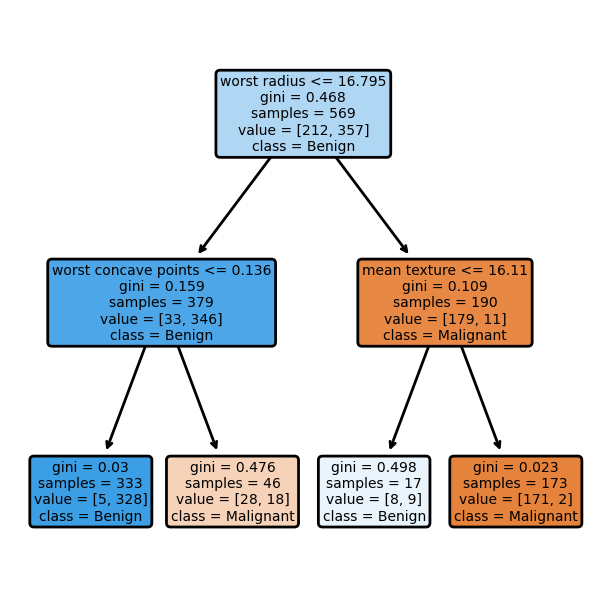

In [138]:
# Visualize Decision Tree
feature_names = list(X.columns)
class_names = ['Malignant', 'Benign'] # Malignant==0, Benign==1

# Init plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=200)
tree.plot_tree(
    clf,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    fontsize=5,
    rounded=True);
fig.tight_layout(pad=3);

### Train/Test split

In [ ]:
# Train/Test Split using Stratified Sampling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Train data: {X_train.shape, y_train.shape}")
print(f"Test data:  {X_test.shape, y_test.shape}")

### Handle imbalanced data

In [ ]:
# SMOTE (Synthetic Minority Oversampling Technique)
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

print(f"Train data: {X_train.shape, y_train.shape}")
print(f"Test data:  {X_test.shape, y_test.shape}")

### Preprocess data
Putting all the steps above together

In [ ]:
# Preprocess data
def preprocess_data(test_size=0.2, oversample=False) -> tuple:
    # Load dataset
    X, y = load_breast_cancer(return_X_y=True, as_frame=True)

    # Train/Test Split using Stratified Sampling
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42)

    # Oversampling using SMOTE
    if oversample:
        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train)

    return X_train, X_test, y_train, y_test

In [ ]:
# Get data
X_train, X_test, y_train, y_test = preprocess_data(test_size=0.2, oversample=True)

print(f"Train data: {X_train.shape, y_train.shape}")
print(f"Test data:  {X_test.shape, y_test.shape}")

In [ ]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
clf.score(y_pred, y_test)

In [ ]:
X = load_breast_cancer()['data'].copy()
y = load_breast_cancer()['target'].copy()

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

smote = SMOTE(random_state = 11)
X_train, y_train = smote.fit_resample(X_train, y_train)
pipeline = Pipeline(steps = [['scaler', StandardScaler()],
                             ['model', DecisionTreeClassifier(random_state=42)]])

stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)
    
param_grid = {
    'model__criterion': ['entropy'],
    'model__max_depth': [1],
    'model__min_samples_leaf': [1]}

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='f1',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')